In [2]:
import os
import time
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Import model and data utilities
from new_version.models import StudentCNN
from new_version.data_utils import RetinalFundusDataset, get_data_transforms, class_names

# Set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Evaluating on device: {device}")

Evaluating on device: cuda


In [3]:
# Paths
BEST_MODEL_PATH = "new_version/models/best_student_model.pth"
QUANT_MODEL_PATH = "new_version/models/optimized/quantized_student_model.pth"
DATA_DIR = "data"

# Parameters 
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 1  
NUM_CLASSES = 4

# Ensure model file exists
if not os.path.isfile(BEST_MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {BEST_MODEL_PATH}")
if not os.path.isfile(QUANT_MODEL_PATH):
    raise FileNotFoundError(f"Quantized model file not found: {QUANT_MODEL_PATH}")

# Ensure test data exists
test_dir = os.path.join(DATA_DIR, "test")
if not os.path.isdir(test_dir):
    raise FileNotFoundError(f"Test data directory not found: {test_dir}")

In [4]:
# Data transforms
transforms_dict = get_data_transforms(IMG_SIZE)
test_dataset = RetinalFundusDataset(root_dir=DATA_DIR, split="test", transform=transforms_dict["test"])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Ensure test set is not empty
if len(test_dataset) == 0:
    raise ValueError("Test dataset is empty!")
print(f"Loaded {len(test_dataset)} test images.")

Loaded 673 test images.


In [5]:
# Function to evaluate model accuracy and measure throughput
def evaluate_model(model, loader, device, class_names):
    """
    Evaluate a model on the test loader, returning accuracy, throughput, targets, and predictions.
    """
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_preds = []
    start_time = time.time()
    with torch.no_grad():
        for images, labels in loader:
            if not isinstance(images, torch.Tensor) or not isinstance(labels, torch.Tensor):
                raise TypeError("Images and labels must be torch.Tensor")
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_targets.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    end_time = time.time()
    elapsed = end_time - start_time
    throughput = total / elapsed if elapsed > 0 else 0
    accuracy = 100.0 * correct / total if total > 0 else 0.0
    return accuracy, throughput, all_targets, all_preds

Best Student Model - Accuracy: 88.56%, Throughput: 2.19 images/sec
              precision    recall  f1-score   support

    Cataract       0.95      0.86      0.90       104
          DR       0.97      0.92      0.94       167
    Glaucoma       0.84      0.69      0.76       131
      Normal       0.84      0.97      0.90       271

    accuracy                           0.89       673
   macro avg       0.90      0.86      0.88       673
weighted avg       0.89      0.89      0.88       673



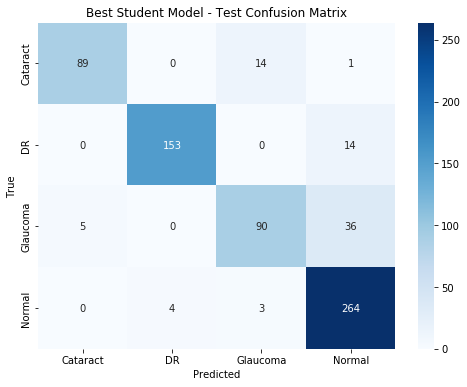

In [6]:
# Evaluate best student CNN model
model_best = StudentCNN(num_classes=NUM_CLASSES, model_name="mobilenet_v2", pretrained=False)
model_best.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model_best = model_best.to(device)
acc_best, throughput_best, targets_best, preds_best = evaluate_model(model_best, test_loader, device, class_names)
print(f"Best Student Model - Accuracy: {acc_best:.2f}%, Throughput: {throughput_best:.2f} images/sec")
print(classification_report(targets_best, preds_best, target_names=class_names))
cm_best = confusion_matrix(targets_best, preds_best)
plt.figure(figsize=(8,6))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Best Student Model - Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Quantized Student Model - Accuracy: 88.56%, Throughput: 5.41 images/sec
              precision    recall  f1-score   support

    Cataract       0.95      0.86      0.90       104
          DR       0.97      0.92      0.94       167
    Glaucoma       0.84      0.69      0.76       131
      Normal       0.84      0.97      0.90       271

    accuracy                           0.89       673
   macro avg       0.90      0.86      0.88       673
weighted avg       0.89      0.89      0.88       673



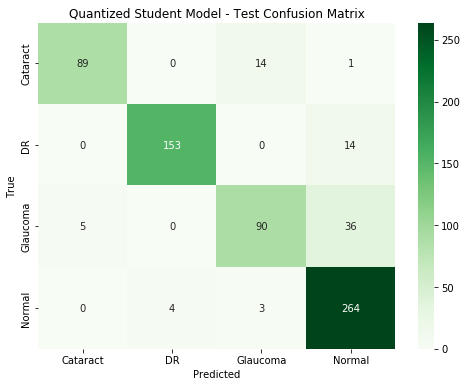

In [7]:
# Evaluate quantized version of student CNN model
model_quant = StudentCNN(num_classes=NUM_CLASSES, model_name="mobilenet_v2", pretrained=False)
model_quant.load_state_dict(torch.load(QUANT_MODEL_PATH, map_location=device))
model_quant = model_quant.to(device)
acc_quant, throughput_quant, targets_quant, preds_quant = evaluate_model(model_quant, test_loader, device, class_names)
print(f"Quantized Student Model - Accuracy: {acc_quant:.2f}%, Throughput: {throughput_quant:.2f} images/sec")
print(classification_report(targets_quant, preds_quant, target_names=class_names))
cm_quant = confusion_matrix(targets_quant, preds_quant)
plt.figure(figsize=(8,6))
sns.heatmap(cm_quant, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title("Quantized Student Model - Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [8]:
# Comparison Summary
print("--- Comparison Summary ---")
print(f"Best Student Model:    Accuracy = {acc_best:.2f}%, Throughput = {throughput_best:.2f} images/sec")
print(f"Quantized Student Model: Accuracy = {acc_quant:.2f}%, Throughput = {throughput_quant:.2f} images/sec")

--- Comparison Summary ---
Best Student Model:    Accuracy = 88.56%, Throughput = 2.19 images/sec
Quantized Student Model: Accuracy = 88.56%, Throughput = 5.41 images/sec
